# Prerequisites

Run the cells below if the named packages are not installed on your evironment yet

# Intro

In this notebook we build a CNN classifier for the problem. The input data for this classifier consists of 1 image of the area plot of the prices over the past month of a stock and the target label represents the future 1 month returns of a stock.

# Define Functions
First, all the necessary functions to train this model are defined

In [1]:
import pandas as pd
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms

from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Create a custom data loader for the train, test, & validation data
class NumericalAndImageDataset(Dataset):
    def __init__(self, overview_file: str, transform=None):
        """
        Initialize this dataloader
        :param overview_file: location of the overview file
        :param transform: transformer for the images
        """
        self.overview= pd.read_csv(overview_file)
        self.transform = transform


    def __len__(self):
        return len(self.overview.index)


    def __getitem__(self, idx):
        img_path_1m = self.overview["1_month_img"].iloc[idx]

        img_1m = Image.open(img_path_1m).convert('RGB') # Store image as RGB (3-channel)

        label = self.overview.label_1m.iloc[idx]

        if self.transform:
            img_1m = self.transform(img_1m)

        return img_1m, label

In [3]:
class OneImageNet(nn.Module):
    def __init__(self):
        super(OneImageNet, self).__init__()

        self.image_1_features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.image_1_flat = nn.Sequential(
            nn.Dropout(p=0.25),
            nn.Linear(15 * 15 * 64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 3)
        )

    def forward(self, img_1):
        step1 = self.image_1_features(img_1)

        step1 = step1.view(step1.size(0), -1)

        step1 = self.image_1_flat(step1)

        return step1

In [4]:
def test(model, test_loader, criterion):
    """
    Test the given model

    :param model: the model to test
    :param test_loader: the dataloader with test data
    :param criterion: the loss criterion used for the test
    :return: loss, accuracy, and actual vs predicted values
    """
    model.eval() # set model to eval mode
    running_loss = 0
    running_corrects = 0
    running_total = 0

    df_collector = []

    for img_1ms, labels in test_loader:
        outputs = model(img_1ms)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * img_1ms.size(0)
        running_corrects += torch.sum(preds == labels.data)

        act_vs_pred_temp = pd.DataFrame({
            "actual": labels.data.numpy(),
            "pred": preds.numpy()
        })

        df_collector.append(act_vs_pred_temp)

        running_total += len(img_1ms)

    total_loss = running_loss / running_total
    total_acc = running_corrects.double() / running_total

    act_vs_pred = pd.concat(df_collector)

    return total_loss, total_acc, act_vs_pred

In [5]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    """
    Train the machine learning model

    :param model: the model to train
    :param train_loader: the data loader with the training data
    :param val_loader: the data loader with the validation data
    :param criterion: the loss criterion used to train the model
    :param optimizer: the optimizer used to train the model
    :param epochs: the number of epochs to train the model
    :return: the model, training accuracies, training losses, validation accuracies, and validation losses
    """
    datasets = {'train':train_loader}

    train_losses = []
    train_accs = []

    val_losses = []
    val_accs = []

    for epoch in range(epochs):

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
                running_loss = 0.0
                running_corrects = 0
                running_total = 0

                for pos, (img_1ms, labels) in enumerate(datasets[phase]):

                    outputs = model(img_1ms)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item() * img_1ms.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    running_total += len(img_1ms)

                train_losses.append(running_loss / running_total)
                train_accs.append(running_corrects / running_total)

            if phase == "valid":
                val_loss, val_acc, _ = test(model, val_loader, criterion)
                val_losses.append(val_loss)
                val_accs.append(val_acc)


    return model, train_losses, train_accs, val_losses, val_accs

In [6]:
def create_data_loaders(batch_size):
    """
    Create the train, validation, and test data loaders

    :param batch_size: the batch size for the data loaders
    :return: the training, validation, and test data loaders
    """
    train_data_path = "ModelData/obs_train.csv"
    test_data_path = "ModelData/obs_test.csv"
    val_data_path = "ModelData/obs_val.csv"

    train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_data = NumericalAndImageDataset(
        overview_file=train_data_path,
        transform=train_transform
    )
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    test_data = NumericalAndImageDataset(
        overview_file=test_data_path,
        transform=test_transform
    )
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    val_data = NumericalAndImageDataset(
        overview_file=val_data_path,
        transform=test_transform
    )
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

    return train_data_loader, test_data_loader, val_data_loader

In [7]:
def build_model(params):
    """
    Train the machine learning model and return statistics on test & validation phases
    :param params: the hyperparameters for the model
    :return: the trained model, training statistics, validation statistics, and test statistics
    """

    train_loader, test_loader, val_loader = create_data_loaders(params["batch_size"])

    model = OneImageNet()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"]) # Use adaptive momentum optimizer

    model, train_losses, train_accs, val_losses, val_accs = train(model, train_loader, val_loader, criterion, optimizer, params["epochs"])

    test_loss, test_acc, act_vs_pred = test(model, test_loader, criterion)

    train_performance = {
        "losses": train_losses,
        "accs": train_accs
    }

    validation_performance = {
        "losses": val_losses,
        "accs": val_accs
    }

    test_performance = {
        "loss": test_loss,
        "acc": test_acc,
        "act_vs_pred": act_vs_pred
    }

    return model, train_performance, validation_performance, test_performance

# Construct Model
Next, the model is trained using a specific selection of hyperparameters (obtained from the hyperparameter tuning from the previous steps) and then finally evaluated on the test set

In [8]:
params = {
    "learning_rate": 0.001480635942514392,
    "epochs": 50,
    "batch_size": 1431
}

model, train_performance, validation_performance, test_performance = build_model(params)

In [10]:
gram_res = {
    "model": model,
    "train_performance": train_performance,
    "validation_performance": validation_performance,
    "test_performance": test_performance
}

In [11]:
import pickle

with open("gram_res.p", "wb") as f:
    pickle.dump(gram_res, f, protocol=pickle.HIGHEST_PROTOCOL)

# Analyse Model Training

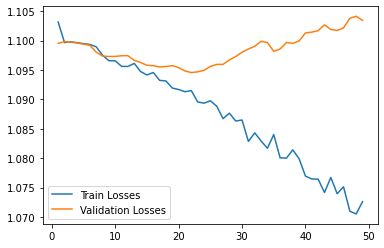

In [25]:
# Construct train loss plot
import matplotlib.pyplot as plt

plt.plot(
    range(1, len(train_performance["losses"])),
    train_performance["losses"][1:],
    label="Train Losses"
)

plt.plot(
    range(1, len(validation_performance["losses"])),
    validation_performance["losses"][1:],
    label="Validation Losses"
)

plt.legend()

plt.show()

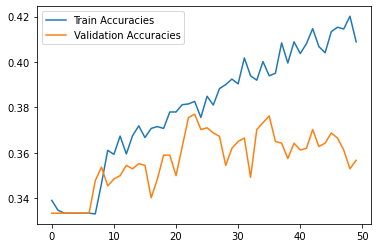

In [24]:
# Construct train accuracy plot
import matplotlib.pyplot as plt

plt.plot(
    range(len(train_performance["accs"])),
    train_performance["accs"],
    label="Train Accuracies"
)

plt.plot(
    range(len(validation_performance["accs"])),
    validation_performance["accs"],
    label="Validation Accuracies"
)

plt.legend()

plt.show()

# Analyse Model Performance

In [14]:
actual_vs_pred = test_performance["act_vs_pred"]

Accuracy

In [15]:
test_performance["acc"]

tensor(0.3799, dtype=torch.float64)

Precision

In [16]:
print("Precision Negative Returns: {}".format(
    len(
        actual_vs_pred[(actual_vs_pred.pred == 0) & (actual_vs_pred.actual == 0)]
    ) / len(
        actual_vs_pred[(actual_vs_pred.pred == 0)].index
    )
))

Precision Negative Returns: 0.3743961352657005


In [17]:
print("Precision Neutral Returns: {}".format(
    len(
        actual_vs_pred[(actual_vs_pred.pred == 1) & (actual_vs_pred.actual == 1)]
    ) / len(
        actual_vs_pred[(actual_vs_pred.pred == 1)].index
    )
))

Precision Neutral Returns: 0.38049713193116635


In [18]:
print("Precision Positive Returns: {}".format(
    len(
        actual_vs_pred[(actual_vs_pred.pred == 2) & (actual_vs_pred.actual == 2)]
    ) / len(
        actual_vs_pred[(actual_vs_pred.pred == 2)].index
    )
))

Precision Positive Returns: 0.3848101265822785


Recall

In [19]:
print("Recall Negative Returns: {}".format(
    len(
        actual_vs_pred[(actual_vs_pred.pred == 0) & (actual_vs_pred.actual == 0)]
    ) / len(
        actual_vs_pred[(actual_vs_pred.actual == 0)].index
    )
))

Recall Negative Returns: 0.3490990990990991


In [20]:
print("Recall Neutral Returns: {}".format(
    len(
        actual_vs_pred[(actual_vs_pred.pred == 1) & (actual_vs_pred.actual == 1)]
    ) / len(
        actual_vs_pred[(actual_vs_pred.actual == 1)].index
    )
))

Recall Neutral Returns: 0.44819819819819817


In [21]:
print("Recall Positive Returns: {}".format(
    len(
        actual_vs_pred[(actual_vs_pred.pred == 2) & (actual_vs_pred.actual == 2)]
    ) / len(
        actual_vs_pred[(actual_vs_pred.actual == 2)].index
    )
))

Recall Positive Returns: 0.34234234234234234
